In [1]:
using Revise

In [1]:
import GaussianMcmc
using GaussianMcmc: Trajectory, SMCEstimate, DirectMCEstimate, marginal_configuration, MarginalEnsemble, ConditionalEnsemble, gene_expression_system, generate_configuration, logpdf, cooperative_chemotaxis_system, reaction_network
using StaticArrays
import Catalyst
using DiffEqBase
using DiffEqJump
import ModelingToolkit
using CairoMakie

In [4]:
params = (;
    E₀ = 3.0,
    lmax = 3,
    mmax = 9,
    Kₐ = 500, # unit: μM (from MeASP data)
    Kᵢ = 25, # unit: μM
    δf = -1.5,
    k_B = 0.1, # demethylation of active receptor
    k_R = 0.1, # methylation of inactive receptor
    n_clusters = 800,
    k⁺ = 0.05, # ligand binding rate to active or inactive receptor
    n_chey = 10_000,
    mean_l = 50,
    tau_l = 1.0,
    phosphorylate = 0.25e-3,
    dephosphorylate = 0.2
)


(E₀ = 3.0, lmax = 3, mmax = 9, Kₐ = 500, Kᵢ = 25, δf = -1.5, k_B = 0.1, k_R = 0.1, n_clusters = 800, k⁺ = 0.05, n_chey = 10000, mean_l = 50, tau_l = 1.0, phosphorylate = 0.00025, dephosphorylate = 0.2)

In [144]:
# plot recipe for trajectories
# Makie.convert_arguments(t::Trajectory) = (Float32.(t.t),Float32.(vcat((vec(u) for u in t.u)...)))
function Makie.convert_arguments(P::PointBased, x::GaussianMcmc.Trajectory)
    t_vals = eltype(x.t)[]
    u_vals = eltype(x.u)[]
    i = 1
    while i < length(x.t)
        push!(t_vals, x.t[i])
        push!(u_vals, x.u[i])
        i += 1
        push!(t_vals, x.t[i])
        push!(u_vals, x.u[i-1])
    end
    
    Makie.convert_arguments(P, t_vals, vcat(u_vals...))
end

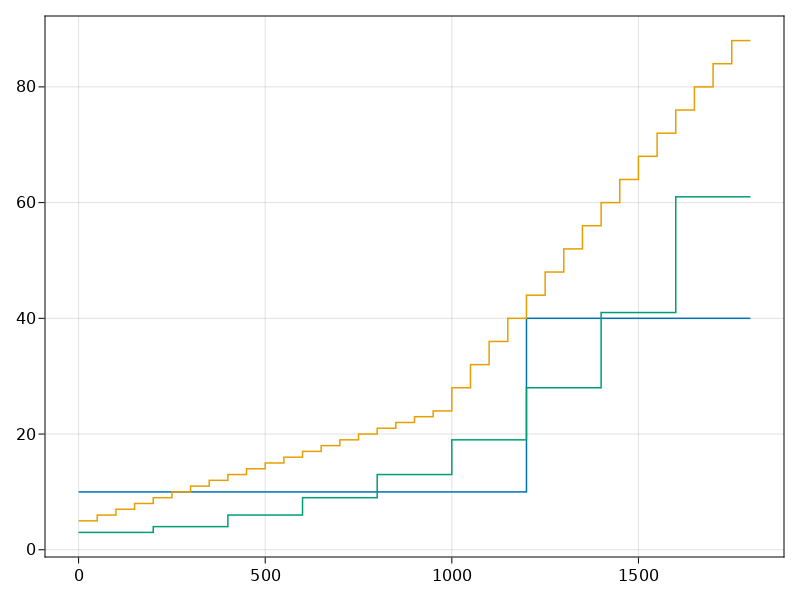

In [145]:
system = cooperative_chemotaxis_system(; dtimes=0.0:1:100, params...)
step_s = Trajectory([[10], [10], [40], [10]], [0, 600, 1200, 1800])
gradient_s = Trajectory(vcat([[x] for x in 5:1:23], [[x] for x in 24:4:92]), collect(0.0:50.0:1800.0))
ramp_s = Trajectory([[round(Int, x)] for x in exp.(range(1, 4.5, length=10))], collect(0:200:1800))
lines(step_s)
lines!(gradient_s)
lines!(ramp_s)
current_figure()

In [109]:
system.pr

9-element Vector{Float64}:
  3.0
  2.995732273553991
 -1.5
  0.05
  0.05
 25.0
  1.25
  0.1
  0.1

In [150]:
function solve_system(system, s_traj, pr=system.pr)
    rx = merge(system.rn, system.xn)

    u0 = copy(system.u0)
    u0[1] = s_traj.u[1][1]
    dprob = DiscreteProblem(rx, u0, (0.0, 1800.0), vcat(pr, system.px))
    jprob = JumpProblem(convert(ModelingToolkit.JumpSystem, rx), dprob, RSSACR())#, save_positions=(false, false))
    driven_prob = GaussianMcmc.DrivenJumpProblem(jprob,  s_traj)
    
    sol = solve(driven_prob)
end

getname(sym) = String(ModelingToolkit.operation(sym).name)

function parse_receptor(species)
    sname = getname(species)
    mtch = match(r"([A-Z])_(\d+)_(\d+)", sname)
    if mtch !== nothing
        # a = mtch.captures[1] == "A"
        l = parse(Int, mtch.captures[2])
        m = parse(Int, mtch.captures[3])
        # (a, l, m) => index
        (l, m)
    else
        nothing
    end
end

using Transducers
function receptor_states(rs)
    smap = Catalyst.speciesmap(rs)
    xf = KeepSomething() do (species, index) 
        result = parse_receptor(species)
        if result === nothing
            nothing
        else
            result => index
        end
    end
    smap |> xf
end

function bound_ligands(sol, rs)
    rstates = receptor_states(rs)
    rstates |> Map(((l, m), i)::Pair -> l .* sol[i,:]) |> sum
end

function bound_methyl(sol, rs)
    rstates = receptor_states(rs)
    rstates |> Map(((l, m), i)::Pair -> m .* sol[i,:]) |> sum
end

p_active(l, m) = 1 / (1 + exp(E0 + l*δg + m*δf))

function active_receptors(sol, rs)
    rstates = receptor_states(rs)
    rstates |> Map(((l, m), i)::Pair -> p_active(l, m) .* sol[i,:]) |> sum
end

function inactive_receptors(sol, rs)
    rstates = receptor_states(rs)
    rstates |> Map(((l, m), i)::Pair -> (1-p_active(l, m)) .* sol[i,:]) |> sum
end

function plot_solution(sol, system; kwargs...)
    joint = reaction_network(system)
    t = sol.t
    lines(t, vec(sol[1,:]) ./ maximum(sol[1,:]), label="ligand concentration")
    lines!(t, active_receptors(sol, joint) ./ n_clusters, label="active fraction")
    lines!(t, vec(sol[end-1,:]) ./ 10000, label="Yp / (Y+Yp)")
    lines!(t, bound_ligands(sol, joint) ./ (lmax * n_clusters), label="bound receptor fraction")
    lines!(t, bound_methyl(sol, joint) ./ (mmax * n_clusters), label="methylated receptors")
    current_figure()
end

plot_solution (generic function with 1 method)

  4.438805 seconds (8.83 M allocations: 3.833 GiB, 25.93% gc time)


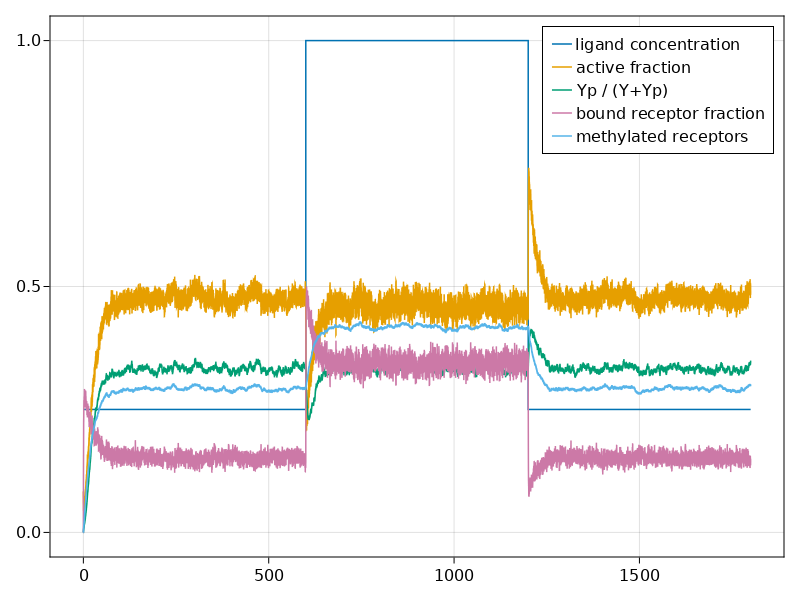

In [152]:
@time sol = solve_system(system, step_s)

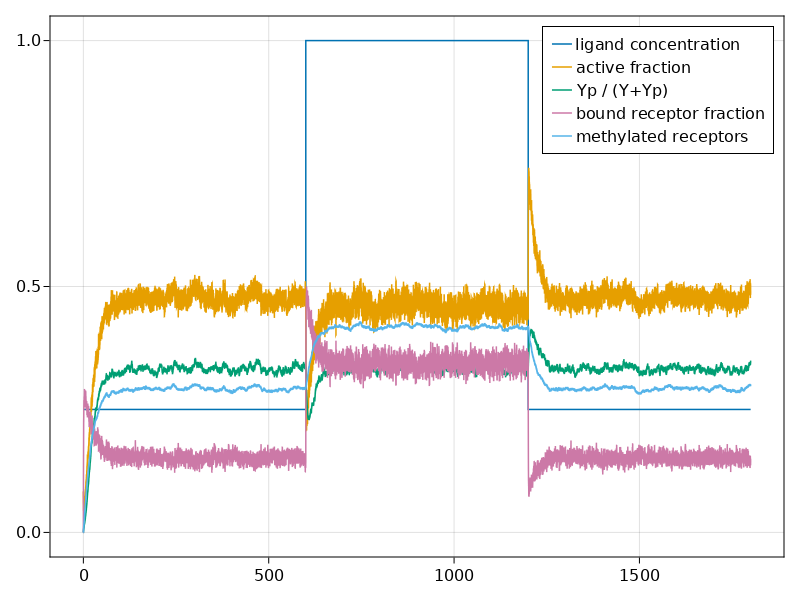

In [153]:
fig = plot_solution(sol, system, title="Fig. 1 Perfect adaptation for step input")
axislegend()
fig

# Deactivate Methylation

In [38]:
factor = 1.0
E0 = -2 # we assume every receptor has a given methylation level
params_no_methylation = [
    E0, # E0
    δg,
    δf,
    factor * p_bind, # ligand binding to active receptor
    p_bind, # ligand binding to inactive receptor
    factor * p_bind * K_a, # ligand dissociation from active receptor
    p_bind * K_i, # ligand dissociation from inactive receptor
    0.0, # demethylation of active receptor
    0.0  # methylation of inactive receptor
]

9-element Vector{Float64}:
 -2.0
  2.995732273553991
 -1.0
  0.05
  0.05
 25.0
  1.25
  0.0
  0.0

In [39]:
mwc_pa(l) = exp(-E0) * (1 + l/K_a)^lmax / ( (1 + l/K_i)^lmax + exp(-E0) * (1 + l/K_a)^lmax )

mwc_pa (generic function with 1 method)

  1.479297 seconds (113.76 k allocations: 6.874 MiB)


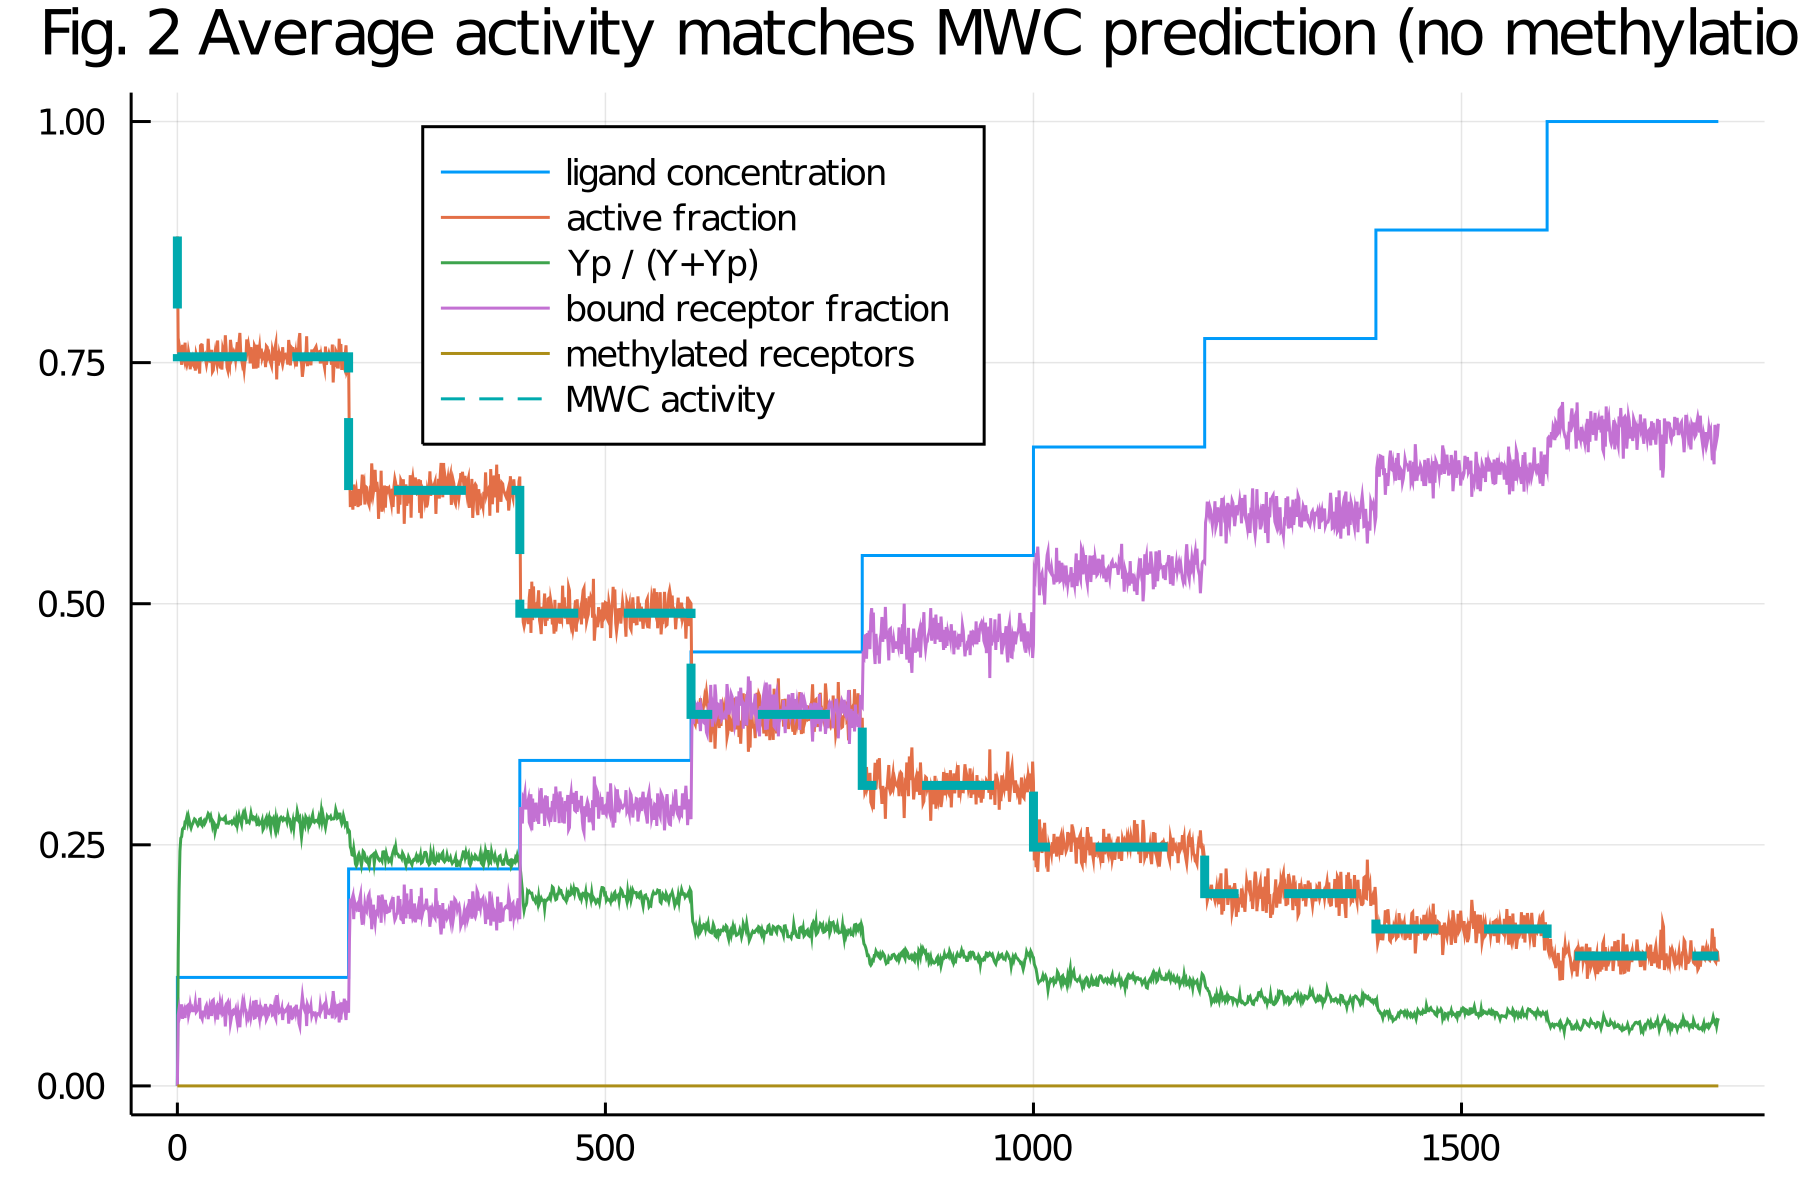

In [40]:
@time sol = solve_system(system, ramp_s, params_no_methylation)
p = plot_solution(sol, system, legend=:top)
plot!(p, ramp_s.t, mwc_pa.(getindex.(ramp_s.u, 1)), seriestype=:steppre, linestyle=:dash, linewidth=3, label="MWC activity", fmt=:png, dpi=300, title="Fig. 2 Average activity matches MWC prediction (no methylation)")

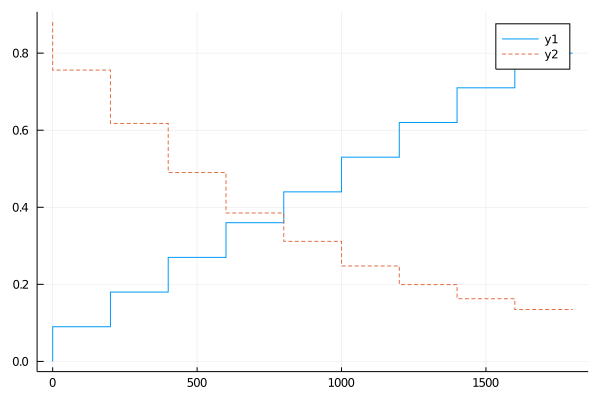

In [41]:
p = plot(ramp_s.t, getindex.(ramp_s.u, 1) ./ 100, seriestype=:steppre)
plot!(p, ramp_s.t, mwc_pa.(getindex.(ramp_s.u, 1)), seriestype=:steppre, linestyle=:dash)

In [50]:
using Printf

println("R_l_k: Receptor with l bound ligands and k-times methylated")
for r in Catalyst.reactions(system.rn)
    f = ModelingToolkit.build_function(r.rate, Catalyst.params(system.rn), expression=Val{false})
    l, m = parse_receptor(r.substrates[1])
    @printf "%s --> %s ; k = %6.3f ; p_active = %.3f\n" getname(r.substrates[1]) getname(r.products[1]) f(params) p_active(l, m)
end

R_l_k: Receptor with l bound ligands and k-times methylated
R_0_1 --> R_0_0 ; k =  0.002 ; p_active = 0.047
R_0_0 --> R_0_1 ; k =  0.049 ; p_active = 0.018
R_0_2 --> R_0_1 ; k =  0.006 ; p_active = 0.119
R_0_1 --> R_0_2 ; k =  0.048 ; p_active = 0.047
R_0_3 --> R_0_2 ; k =  0.013 ; p_active = 0.269
R_0_2 --> R_0_3 ; k =  0.044 ; p_active = 0.119
R_0_4 --> R_0_3 ; k =  0.025 ; p_active = 0.500
R_0_3 --> R_0_4 ; k =  0.037 ; p_active = 0.269
R_0_5 --> R_0_4 ; k =  0.037 ; p_active = 0.731
R_0_4 --> R_0_5 ; k =  0.025 ; p_active = 0.500
R_0_6 --> R_0_5 ; k =  0.044 ; p_active = 0.881
R_0_5 --> R_0_6 ; k =  0.013 ; p_active = 0.731
R_0_7 --> R_0_6 ; k =  0.048 ; p_active = 0.953
R_0_6 --> R_0_7 ; k =  0.006 ; p_active = 0.881
R_0_8 --> R_0_7 ; k =  0.049 ; p_active = 0.982
R_0_7 --> R_0_8 ; k =  0.002 ; p_active = 0.953
R_0_9 --> R_0_8 ; k =  0.050 ; p_active = 0.993
R_0_8 --> R_0_9 ; k =  0.001 ; p_active = 0.982
R_0_0 --> R_1_0 ; k =  0.150 ; p_active = 0.018
R_1_0 --> R_0_0 ; k =  1.272

In [120]:
Catalyst.numreactions(system.rn) + Catalyst.numreactions(system.xn)

173